# LSTM

## import packages

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn import preprocessing

import os
import time
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# check if the tensorflow can see the GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## construct TrainTest dataset

In [3]:
class TrainTest(object):
    def __init__(self, ticker):
        self.ticker = ticker
    
    def readxl(self,inputs):
        '''
        load raw dataset from excel file and declare the input columns
        '''
        self.df = pd.read_csv(self.ticker+'.csv')
        self.df.columns = inputs
        # return self.df

    def scale(self,features):
        '''
        apply MinMaxScaler to features
        '''
        self.features = features
        self.dfsc = self.df.copy()
        for f in features:
            self.scaler = preprocessing.MinMaxScaler()
            self.dfsc[f] = self.scaler.fit_transform(np.expand_dims(self.dfsc[f].values,axis=1))

    def traintestsplit(self, back_steps, test_size):
        '''
        This Neural Network aims to predict the adjusted close price of stock index
        on the next day by learning OCHLV information of the past {back_steps} days.

        X: inputs of the network, 3-D
        y: objective of the network, 1-D
        '''
        # y
        self.dfsc['y_true'] = self.dfsc['adjclose'].shift(-1)
        self.dfsc.dropna(inplace=True)
        self.y = self.dfsc['y_true'].values[back_steps-1:]
        
        # X
        pkg = deque(maxlen=back_steps)
        dataset = self.dfsc[self.features].values
        X = list()
        for v in dataset:
            pkg.append(v)
            if len(pkg) == back_steps:
                X.append(np.array(pkg))
        self.X = np.array(X)

        # Manual train test split instead of train_test_split from sklearn
        train_size = len(self.y) - test_size
        self.X_train = self.X[:train_size]
        self.y_train = self.y[:train_size]
        self.X_test = self.X[train_size:]
        self.y_test = self.y[train_size:]
        self.resultdf = pd.DataFrame(index=self.dfsc.date[len(self.dfsc)-test_size:])

In [4]:
back = 60 # machine learns OCHLV info of the past 60 days
test = 250 # the test set has 250 trading days
ipts = ['date','open','high','low','adjclose','volume','size'] # declare excel file colnames
feats = ['adjclose','volume','size','open', 'high', 'low'] # feature vector of the neural network

In [5]:
ssec = TrainTest('SZ') # SSE Composite Index, SZ.csv is filename
ssec.readxl(inputs=ipts)
ssec.scale(features=feats)
ssec.traintestsplit(back_steps=back, test_size=test)

## train & predict

In [6]:
class StockRNN(object):
    def __init__(self, ticker, X_train, y_train, X_test, y_test, result):
        self.ticker = ticker
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.result = result
    
    def genModel(self, cell, back_steps, n_features, n_layers, units, units_input, units_last, dropout, loss, metrics, optimizer):
        # create and compile model
        self.cell = cell
        self.layers = n_layers
        self.loss = loss
        self.metrics = metrics
        self.optimizer = optimizer

        model = Sequential()
        if n_layers > 2:
            for i in range(n_layers):
                if i == 0:
                    # input layer
                    model.add(cell(units_input, return_sequences=True, batch_input_shape=(None, back_steps, n_features)))
                elif i == n_layers-1:
                    # last layer before output
                    model.add(cell(units_last, return_sequences=False))
                else:
                    # hidden layers
                    model.add(cell(units, return_sequences=True))
                # regularization technique: Dropout
                model.add(Dropout(dropout))
        elif n_layers == 2:
            model.add(cell(units_input, return_sequences=True, batch_input_shape=(None, back_steps, n_features)))
            model.add(cell(units_last, return_sequences=False))            

        model.add(Dense(1)) # output layer
        model.compile(loss=self.loss, metrics=self.metrics, optimizer=self.optimizer)
        self.model = model
    
    def fitModel(self, BATCH_SIZE, EPOCHS):
        # generate train log
        if not os.path.isdir('results'):
            os.mkdir('results')
        if not os.path.isdir('logs'):
            os.mkdir('logs')
        if not os.path.isdir('data'):
            os.mkdir('data')
        
        self.time_now = time.strftime('%Y_%m_%d-%H_%M_%S')
        model_name = f'{self.ticker}_{self.time_now}_{self.layers}layers_{self.loss}_{self.metrics}_{self.optimizer}'
        
        # some tensorflow callbacks
        checkpointer = ModelCheckpoint(os.path.join('results', model_name + '.h5'), save_weights_only=True, save_best_only=True, verbose=1)
        tensorboard = TensorBoard(log_dir=os.path.join('logs', model_name))
        earlystopping = EarlyStopping(patience=10) # if loss doesn't improve in 10 epochs, the training process will be stopped

        # fit model
        history = self.model.fit(self.X_train, self.y_train,
                                    batch_size = BATCH_SIZE,
                                    epochs = EPOCHS,
                                    validation_split=0.3,
                                    callbacks=[checkpointer, tensorboard, earlystopping],
                                    verbose=1)
    
    def Modelpred(self,scaler):
        # predict y by the trained Neural Network
        y_pred = self.model.predict(self.X_test)
        y_pred = np.squeeze(scaler.inverse_transform(y_pred))
        y_test = np.squeeze(scaler.inverse_transform(np.expand_dims(self.y_test, axis=1)))
        self.result['y_true'] = y_test
        self.result['y_pred'] = y_pred
        
        # performance metrics
        m = RootMeanSquaredError()
        m.update_state(self.result['y_true'].values,self.result['y_pred'].values)
        self.perform = m.result().numpy()

    def visualModel(self):
        # visualize the final results
        plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':120})
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.plot(self.result.loc[:,'y_true'],'b')
        ax.plot(self.result.loc[:,'y_pred'],'r')
        ax.legend(['Actual Price','Predicted Price'])
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        plt.gcf().autofmt_xdate()
        plt.savefig(f'{self.ticker}_{self.time_now}_LSTM.png')

In [7]:
ssec_lstm = StockRNN(ticker='ssec', X_train=ssec.X_train, y_train=ssec.y_train, 
                     X_test=ssec.X_test, y_test=ssec.y_test, result=ssec.resultdf)

In [8]:
ssec_lstm.genModel(cell = LSTM, back_steps=back, n_features=len(feats), n_layers=2,
                   units=8, units_input=16, units_last = 4, dropout=0.4,
                   loss='mean_squared_error', metrics = 'mean_squared_error', optimizer='adam')

In [9]:
ssec_lstm.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 16)            1472      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 1,813
Trainable params: 1,813
Non-trainable params: 0
_________________________________________________________________


In [10]:
ssec_lstm.fitModel(BATCH_SIZE=20, EPOCHS=300)

Epoch 1/300
249/249 [==============================] - 7s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 9.9507e-04 - val_mean_squared_error: 9.9507e-04

Epoch 00001: val_loss improved from inf to 0.00100, saving model to results\ssec_2021_07_06-15_52_53_2layers_mean_squared_error_mean_squared_error_adam.h5
Epoch 2/300
249/249 [==============================] - 3s 12ms/step - loss: 3.8510e-04 - mean_squared_error: 3.8510e-04 - val_loss: 5.4202e-04 - val_mean_squared_error: 5.4202e-04

Epoch 00002: val_loss improved from 0.00100 to 0.00054, saving model to results\ssec_2021_07_06-15_52_53_2layers_mean_squared_error_mean_squared_error_adam.h5
Epoch 3/300
249/249 [==============================] - 3s 13ms/step - loss: 3.0702e-04 - mean_squared_error: 3.0702e-04 - val_loss: 4.6459e-04 - val_mean_squared_error: 4.6459e-04

Epoch 00003: val_loss improved from 0.00054 to 0.00046, saving model to results\ssec_2021_07_06-15_52_53_2layers_mean_squared_error_mean_squared_error_

In [11]:
ssec_lstm.Modelpred(scaler=ssec.scaler)
ssec_lstm.perform

137.91055

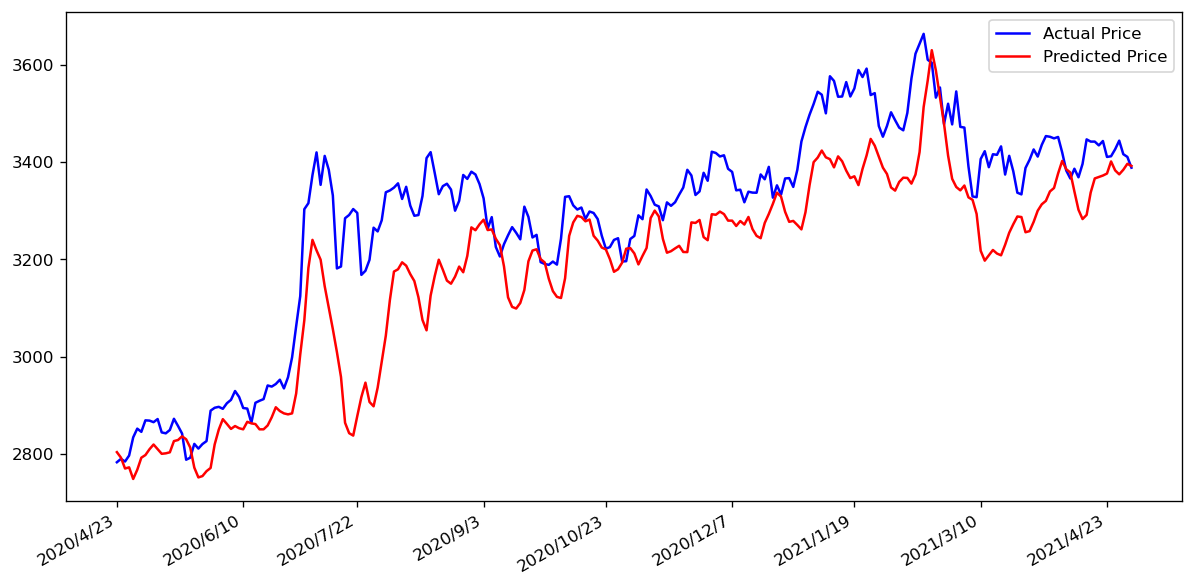

In [12]:
ssec_lstm.visualModel()

# ARIMA

## import packages

In [13]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

## construct TrainTest dataset

In [14]:
adjc_total = ssec.df.loc[:,['date','adjclose']]
adjc_total.drop([len(adjc_total)-1],inplace=True) # reconcile the test set with LSTM
adjc_total.set_index('date',inplace=True)
adjc_total.index = pd.to_datetime(adjc_total.index)
adjc_total.dropna(inplace=True)
adjc_total

,adjclose
date,
1990-12-20,104.3900
1990-12-21,109.1300
1990-12-24,114.5500
1990-12-25,120.2500
1990-12-26,125.2700
...,...
2021-04-27,3442.6111
2021-04-28,3457.0683
2021-04-29,3474.9011


In [15]:
ytestdf = ssec.resultdf
test_start_date = ytestdf.index[0]
test_start_date = datetime.datetime.strptime(test_start_date, "%Y/%m/%d")
test_start_date # get the start point of test set

datetime.datetime(2020, 4, 23, 0, 0)

In [16]:
adjc_init = adjc_total[adjc_total.index<test_start_date]
adjc_test = adjc_total[adjc_total.index>=test_start_date]

In [17]:
adjc_init

,adjclose
date,
1990-12-20,104.3900
1990-12-21,109.1300
1990-12-24,114.5500
1990-12-25,120.2500
1990-12-26,125.2700
...,...
2020-04-16,2819.9350
2020-04-17,2838.4945
2020-04-20,2852.5528


In [18]:
adjc_test

,adjclose
date,
2020-04-23,2838.4994
2020-04-24,2808.5293
2020-04-27,2815.4947
2020-04-28,2810.0243
2020-04-29,2822.4424
...,...
2021-04-27,3442.6111
2021-04-28,3457.0683
2021-04-29,3474.9011


In [19]:
arimatestdate = adjc_test.index
test_df_arima = pd.DataFrame(index=arimatestdate, columns=['y_true','y_pred'])
test_df_arima

,y_true,y_pred
date,,
2020-04-23,NaN,NaN
2020-04-24,NaN,NaN
2020-04-27,NaN,NaN
2020-04-28,NaN,NaN
2020-04-29,NaN,NaN
...,...,...
2021-04-27,NaN,NaN
2021-04-28,NaN,NaN
2021-04-29,NaN,NaN


## estimate & predict

In [20]:
model = pm.auto_arima(np.array(adjc_init.adjclose.values), start_p=1, start_q=1,
                  information_criterion='aic',
                  test='kpss',       # use unit root test to find optimal 'd'
                  max_p=12, max_q=12, # maximum p and q
                  with_intercept=True,
                  m=1,              # frequency of series, corresponding to seasonality
                  d=None,           # let model determine 'd'
                  seasonal=False,   # No Seasonality
                  start_P=0, 
                  D=0, 
                  trace=True,
                  error_action='warn',  
                  suppress_warnings=True, 
                  stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73621.318, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=73614.044, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=73606.511, Time=0.58 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=73593.182, Time=1.48 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=73567.830, Time=0.98 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=73569.315, Time=1.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73614.741, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=73603.780, Time=2.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=73605.129, Time=3.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=73580.829, Time=3.06 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=73569.616, Time=2.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73607.152, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=73604.580, Time=2.43 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=73578.454, Time=6.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=73552.887, Time=5.27

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7172
Model:               SARIMAX(3, 1, 2)   Log Likelihood              -36769.204
Date:                Tue, 06 Jul 2021   AIC                          73552.408
Time:                        15:54:39   BIC                          73600.552
Sample:                             0   HQIC                         73568.977
                               - 7172                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4472      0.810      0.552      0.581      -1.140       2.035
ar.L1          0.1981      0.021      9.537      0.000       0.157       0.239
ar.L2         -0.8719      0.016    -55.724      0.000      -0.903      -0.841
ar.L3          0.0680      0.006     10.630      0.000       0.055       0.081
ma.L1         -0.1619      0.020     -7.954      0.000      -0.202      -0.122
ma.L2          0.8306      0.018     46.117      0.000       0.795       0.866
sigma2      1662.2381      8.532    194.830      0.000    1645.516    1678.960
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            122025.28
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
testlen = len(arimatestdate)
arimaytest = model.predict(testlen)
test_df_arima['y_true'] = adjc_test.adjclose
test_df_arima['y_pred'] = arimaytest

In [23]:
m = RootMeanSquaredError()
m.update_state(test_df_arima['y_true'].values,test_df_arima['y_pred'].values)
m.result().numpy()

473.85797

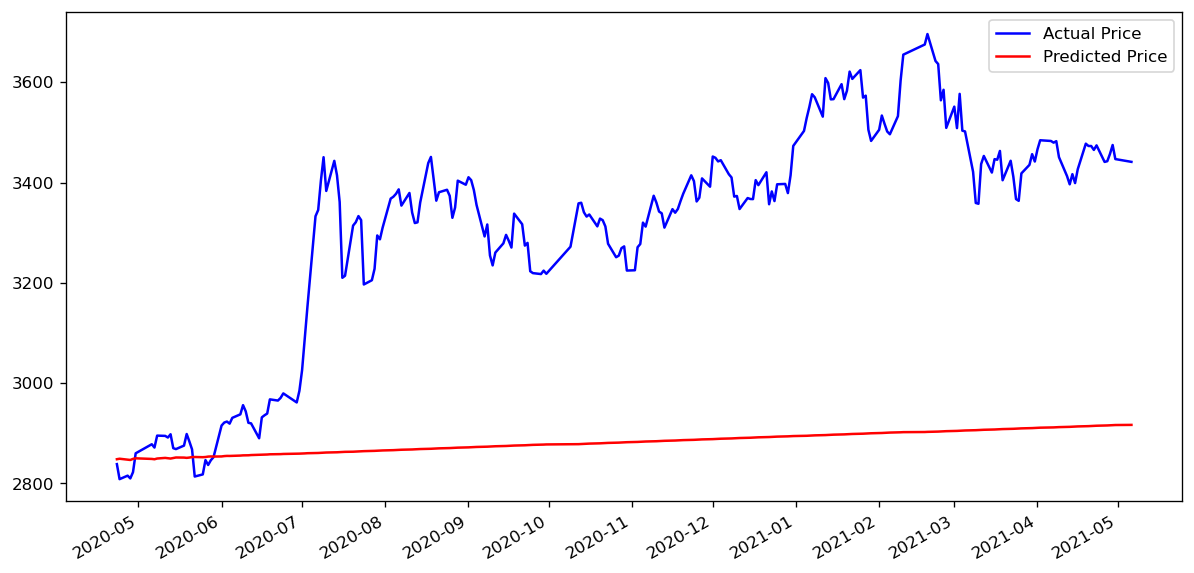

In [24]:
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':120})
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(test_df_arima.loc[:,'y_true'],'b')
ax.plot(test_df_arima.loc[:,'y_pred'],'r')
ax.legend(['Actual Price','Predicted Price'])
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.savefig(f'{ssec_lstm.ticker}_{ssec_lstm.time_now}_arima.png')